# Audio Similarity Search

In this notebook we'll build a content-based audio similarity search system: given a short sound clip, we turn it into a vector embedding with a pretrained audio-tagging model, store those vectors in a Pinecone index, and then retrieve the most relevant results.

Audio similarity search systems are used in various fields. In music tech, they suggest tracks with a similar timbre or texture to a seed clip, helping build cohesive playlists and spot near-duplicates in catalogs. In post-production for film/TV, game studios and podcast teams, they let editors search huge SFX libraries by "sound-alike" to quickly find alternate takes or variations, even when filenames or tags are inconsistent. In contact centers and QA/compliance, they automatically flag recurring audio motifs across thousands of calls such as hold music, IVR beeps, or alarm tones so teams can monitor policy adherence, improve customer experience and streamline auditing.

# 1. Loading the Data

We'll be working with the ESC-50 (Environmental Sound Classification 50) dataset, which contains 2000 sounds spanning 50 semantic classes such as "chirping_birds", "crow" and "fireworks".

> Data source: https://huggingface.co/datasets/ashraq/esc50

In [ ]:
import numpy as np
import pandas as pd
import os

from pinecone import Pinecone, ServerlessSpec

# For loading and analysing audio files
import librosa
from IPython.display import Audio, display
import IPython.display as ipd
from IPython.display import Audio as Ipa

# Library that provides audio embedding models and reference tools for generating vectors
import panns_inference

# For progress bar
from tqdm.notebook import tqdm

from datasets import load_dataset
from datasets import Audio

import torch

In [ ]:
data = load_dataset("ashraq/esc50", split = "train")

Repo card metadata block was not found. Setting CardData to empty.


Let's preview the data in a DataFrame. There are several columns:

- filename: the WAV file name
- fold: integer indicating cross‑validation fold (1–5)
- target: numeric class ID (0–49)
- category: human‑readable sound label
- esc10: boolean flag if it's part of the 10‑class ESC‑10 subset
- src_file: original source identifier
- take: version or fragment label
- audio: decoded audio data object including duration and samples


In [ ]:
preview_df = pd.DataFrame({c: data[c][:5] for c in data.column_names})
preview_df

,filename,fold,target,category,esc10,src_file,take,audio
0,1-100032-A-0.wav,1,0,dog,True,100032,A,<datasets.features._torchcodec.AudioDecoder ob...
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A,<datasets.features._torchcodec.AudioDecoder ob...
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A,<datasets.features._torchcodec.AudioDecoder ob...
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B,<datasets.features._torchcodec.AudioDecoder ob...
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A,<datasets.features._torchcodec.AudioDecoder ob...


We'll display 1 audio file that we are selecting using its index from "data". In the result below, we can see:
- `data (shape)`: 1 means there's one audio channel (mono), and the total number of samples is 220 500
- `duration_seconds`: the audio is 5 seconds long
- `sample_rate`: 44 100 measurements (samples) per second were taken when recording (this is a standard for high-quality audio)

In [ ]:
audio_dec = data[10]["audio"]
samples = audio_dec.get_all_samples()
samples

AudioSamples:
  data (shape): torch.Size([1, 220500])
  pts_seconds: 0.0
  duration_seconds: 5.0
  sample_rate: 44100

When we look at `samples.data`, we’re seeing the raw waveform. It is a long list of floating-point amplitudes (volume levels) between -1.0 and 1.0.

- positive values: parts of the wave that move upward
- negative values: parts of the wave that move downward
- values near zero: moments of silence or very low volume



In [ ]:
samples.data[0, :10]

tensor([3.0518e-05, 3.0518e-05, 3.0518e-05, 3.0518e-05, 3.0518e-05, 3.0518e-05,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00])

# 2. Playing the Audio file

Let's play the audio file so we can hear what is acutally sounds like. We'll extract its waveform array and then use Ipython's `Audio` widget to play it directly in the notebook:

In [ ]:
# Choosing index (from 0 to 1999)
sound_num = 10

# Taking the "array" tha represents the actual sound
sound_array = data[sound_num]["audio"]['array']

# Printing the category of sound
print(data[sound_num]["category"])

# Playing
ipd.Audio(sound_array, rate = 44100)

door_wood_knock


# 3. Initializing the Auto-Tagging Model for Embeddings

Next, we will initialize **AudioTagging model** from `panns_inference` library. This model is based on PANNs (Pretrained Audio Neural Networks), a family of convolutional neural networks trained on the large-scale AudioSet dataset. The model takes an audio waveform as input and produce **2048-dimensional embedding vector**.

> NOTE: The model will try to download its pretrained weights using the wget command-line tool. Make sure wget is installed and available on your system. If it's not available, run first `apt-get update` and then `apt-get install wget`. On macOS (with Homebrew installed) run `brew install wget`.

In [ ]:
from panns_inference import AudioTagging

# Downloading the pretrained model weights
model = AudioTagging(checkpoint_path = None)

Checkpoint path: /Users/jankagecelovska/panns_data/Cnn14_mAP=0.431.pth
Using CPU.


We will resample all clips to 32 kHz because the PANNs checkpoint was trained at 32 kHz and its front-end is sample-rate–dependent. Feeding 44.1 kHz would shift the time/frequency scale, yielding embeddings that don’t align or compare well across files.

In [ ]:
resampled_data = data.cast_column("audio", Audio(sampling_rate=32000))

Let’s extract one audio file and compute its embedding for quick visual exploration:

In [ ]:
# Selecting audio file with index 10
sound_num = 10
text_audio_file = resampled_data[sound_num]

# Extracting the raw waveform from the "audio" column
sound_array = text_audio_file["audio"]["array"].astype("float32")
# Storing the sampling rate
sr = text_audio_file["audio"]["sampling_rate"]

We'll use `inference()` method on audio file that we stored in "sound_array". This method returns 2 outputs:
- "probabilities" = array of class probabilities
- "audio_vec" = embedding vector of the sound

In [ ]:
probabilities, audio_vec = model.inference(sound_array[None, :])

In [ ]:
# Class probabilities
probabilities

array([[2.27117985e-02, 4.26029757e-04, 4.97796282e-04, 4.80239309e-04,
        3.58336765e-05, 4.54999390e-04, 4.03176091e-05, 1.05042622e-04,
        5.33132916e-05, 8.72265737e-05, 2.06835219e-04, 6.70714508e-05,
        5.02933799e-05, 6.72252645e-05, 8.60936998e-05, 3.99378478e-05,
        3.26797919e-04, 1.00437021e-04, 6.65072148e-05, 4.71860258e-04,
        8.49206190e-05, 2.22254399e-04, 6.54192045e-05, 7.72829153e-05,
        9.54457646e-05, 1.00079516e-03, 7.57888920e-05, 1.27479737e-03,
        1.03767472e-03, 7.53365239e-05, 3.80767597e-04, 5.20703848e-04,
        3.50809802e-04, 4.91853571e-04, 2.65525567e-04, 6.56886317e-04,
        1.01830439e-04, 4.93306834e-05, 4.74901812e-04, 3.51327035e-04,
        7.08700973e-05, 3.92826769e-05, 5.13449891e-07, 3.26455265e-05,
        8.59595748e-05, 2.55785599e-05, 1.23660066e-04, 1.00385987e-04,
        1.23752707e-05, 1.74509551e-04, 7.69967028e-06, 7.76911329e-04,
        1.68884319e-04, 4.17201919e-03, 1.39769609e-05, 3.408709

In [ ]:
# 2048-dimensional embedding vector
audio_vec.shape[1]

2048

# 4. Creating an Index in Pinecone

We’ll now create a Pinecone index to store our audio embeddings. Dimension must match our model output, 2048 in this case.

In [ ]:
pinecone_client = Pinecone(api_key=os.getenv("PINECONE_API_KEY"))

In [ ]:
# Creating an index
pinecone_client.create_index(name = "audio-files",
                             dimension = 2048,
                             metric = 'cosine',
                             spec = ServerlessSpec(
                                 cloud = "aws",
                                 region = "us-east-1")
                            )

{
    "name": "audio-files",
    "metric": "cosine",
    "host": "audio-files-lxoswle.svc.aped-4627-b74a.pinecone.io",
    "spec": {
        "serverless": {
            "cloud": "aws",
            "region": "us-east-1"
        }
    },
    "status": {
        "ready": true,
        "state": "Ready"
    },
    "vector_type": "dense",
    "dimension": 2048,
    "deletion_protection": "disabled",
    "tags": null
}

# 5. Creating Audio Embeddings

Instead of loading all 2000 audio files into memory at once, we process them in mini-batches. For each iteration, the function takes a slice of the dataset containing up to 64 audio clips, converts each waveform into a NumPy array and stacks them together into a single 2D array.

In [ ]:
def iter_batches(ds, batch_size=64):
    for i in range(0, len(ds), batch_size):
        batch = ds[i:i+batch_size]  # columnar dict: keys are column names

        # Waveforms: list of dicts under batch["audio"], each has {"array", "sampling_rate"}
        waves = np.stack(
            [a["array"].astype("float32") for a in batch["audio"]],
            axis=0
        )

        yield waves, batch

Each batch of audio waveforms is passed to `inference()` method, which turns them into 2048-dimensional embedding vectors. At the same time, we also save an ID for each audio file and some extra info like its category:

In [ ]:
embeddings = []  # will hold the 2048-D vectors for each audio clip
metas = []       # will hold metadata dictionaries (category, filename)
ids = []         # will hold unique IDs (filenames) for Pinecone

for waves, batch in tqdm(iter_batches(resampled_data, batch_size=64),
                         total = (len(resampled_data)+63)//64,
                         desc = "Creating embeddings"):
    # Converting waveforms into embeddings
    _, emb = model.inference(waves)
    # Storing results
    embeddings.extend(emb.tolist())

    # IDs & metadata from the column lists
    ids.extend([str(fn) for fn in batch["filename"]])
    metas.extend({"category": str(cat), "filename": str(fn)}
                 for cat, fn in zip(batch["category"], batch["filename"]))

Creating embeddings:   0%|          | 0/32 [00:00<?, ?it/s]

Once all embeddings and metadata are collected, we store them into a DataFrame:

In [ ]:
df_to_upsert = pd.DataFrame({
    "id": ids,
    "values": embeddings,
    "metadata": metas
})

In [ ]:
df_to_upsert

,id,values,metadata
0,1-100032-A-0.wav,"[0.0, 0.4578041434288025, 0.0, 0.0854055210947...","{'category': 'dog', 'filename': '1-100032-A-0...."
1,1-100038-A-14.wav,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","{'category': 'chirping_birds', 'filename': '1-..."
2,1-100210-A-36.wav,"[0.0, 0.3924626410007477, 0.0, 0.0, 0.0, 0.0, ...","{'category': 'vacuum_cleaner', 'filename': '1-..."
3,1-100210-B-36.wav,"[0.0, 0.44260600209236145, 0.0, 0.0, 0.0, 0.0,...","{'category': 'vacuum_cleaner', 'filename': '1-..."
4,1-101296-A-19.wav,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","{'category': 'thunderstorm', 'filename': '1-10..."
...,...,...,...
1995,5-263831-B-6.wav,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.901660680770874, 0...","{'category': 'hen', 'filename': '5-263831-B-6...."
1996,5-263902-A-36.wav,"[0.0, 0.6399058103561401, 0.0, 0.0, 0.0, 0.0, ...","{'category': 'vacuum_cleaner', 'filename': '5-..."
1997,5-51149-A-25.wav,"[0.0, 1.7218328714370728, 0.0, 0.0, 0.0, 0.0, ...","{'category': 'footsteps', 'filename': '5-51149..."
1998,5-61635-A-8.wav,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.6599751710891724, ...","{'category': 'sheep', 'filename': '5-61635-A-8..."


# 6. Upserting data into Pinecone DB

Now we can upsert the data into the database, using batches of 100 vectors to ensure each request stays within Pinecone’s 2 MB payload limit:

In [ ]:
index = pinecone_client.Index("audio-files")

In [ ]:
index.upsert_from_dataframe(
    df_to_upsert,
    batch_size = 100,
    show_progress = True
)

sending upsert requests:   0%|          | 0/2000 [00:00<?, ?it/s]

{'upserted_count': 2000}

We should now see Record Count updated to 2000 in Pinecone web console.

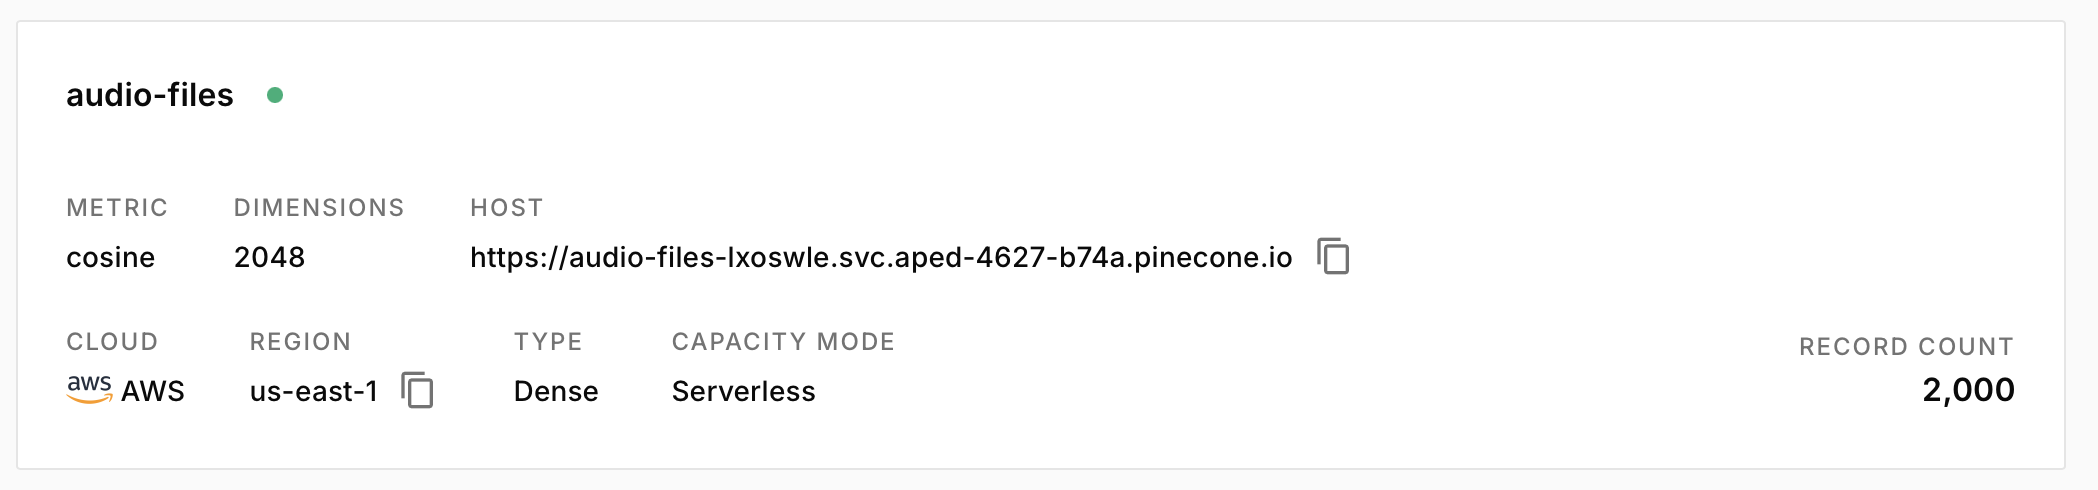

# 7. Audio Search with an Example from the Dataset

Now that we’ve stored all our audio embeddings in Pinecone, we can try searching the index to see how well our system retrieves similar sounds. For this first test, we’ll keep things simple by using in-sample data. That means our query audio will come directly from the same dataset we used to build the index.

This is a useful sanity check because the query clip itself should appear as the top match and other high-scoring results should come from the same sound category.

Let's pick one audio file from "resampled_data" so we can hear what we are searching for:

In [ ]:
# Playing the sound
sound_num = 390
query_clip = resampled_data[sound_num]
query_wave = query_clip["audio"]["array"].astype("float32")
sr = query_clip["audio"]["sampling_rate"]
print(f"Query category: {query_clip['category']} | filename: {query_clip['filename']} | sr: {sr}")
ipd.Audio(query_wave, rate=sr)

Query category: crow | filename: 1-96950-A-9.wav | sr: 32000


Now we'll compute the embedding for this single clip:

In [ ]:
_, emb = model.inference(query_wave[None, :])
query_vector = emb[0].tolist()
len(query_vector)

2048

Now we'll request the top 5 most similar results along with their metadata:

In [ ]:
# Search for similar results
responses = index.query(
    vector = query_vector,
    top_k = 3,
    include_metadata = True
)

Let's print responses:
- The top result ("1-96950-A-9.wav") is an exact match to the query, which is why its similarity score is exactly 1.
- The next two results (IDs "1-96950-B-9.wav" and "2-108766-A-9.wav") are also labeled as "crow" and have high similarity scores, meaning their embeddings are very close to the query vector.

In [ ]:
for response in responses["matches"]:
    print(f"ID: {response['id']}")
    print(f"Score: {response['score']:.4f}")  # 4 decimal places
    metadata = response.get("metadata", {})
    print("Metadata:")
    for key, value in metadata.items():
            print(f" {key}: {value}")
    print("\n" + "-" * 40 + "\n")

ID: 1-96950-A-9.wav
Score: 1.0005
Metadata:
 category: crow
 filename: 1-96950-A-9.wav

----------------------------------------

ID: 1-96950-B-9.wav
Score: 0.9616
Metadata:
 category: crow
 filename: 1-96950-B-9.wav

----------------------------------------

ID: 2-108766-A-9.wav
Score: 0.9533
Metadata:
 category: crow
 filename: 2-108766-A-9.wav

----------------------------------------



We can also play the top matches to confirm that similar sounds are being retrieved:

In [ ]:
filename_to_idx = {fn: i for i, fn in enumerate(resampled_data["filename"])}

for m in responses["matches"][:3]:
    fn = m["id"]                        # filename string
    idx = filename_to_idx[fn]           # row index in resampled_data
    ex = resampled_data[idx]
    print(ex["category"], "|", ex["filename"], "| score:", f"{m['score']:.3f}")
    display(Ipa(ex["audio"]["array"], rate = ex["audio"]["sampling_rate"]))

crow | 1-96950-A-9.wav | score: 1.000


crow | 1-96950-B-9.wav | score: 0.962


crow | 2-108766-A-9.wav | score: 0.953


# 8. Audio Search with a New Sound

In the second example, we'll use an external audio file "frog.wav", which should be placed in the same directory as this notebook, to search database for similar sounds. We first load the audioWe and resample it to 32 kHz so it matches the PANNs model’s training setup.

In [ ]:
own_audio, sample_rate = librosa.load("frogs.wav", sr = 32000)

In [ ]:
ipd.Audio(own_audio, rate = sample_rate)

Then we convert the waveform into an embedding vector using our pretrained audio model:

In [ ]:
# Creating Embedding
_, emb = model.inference(own_audio[None, :])
query_vec = emb[0].tolist()
len(query_vec)

2048

Next, we search Pinecone for top 3 similar sounds in the database:

In [ ]:
# Searching for similar results
responses = index.query(
    vector = query_vec,
    top_k = 3,
    include_metadata = True)

In [ ]:
# Printing the top matches
for response in responses["matches"]:
    print(f"ID: {response['id']}")
    print(f"Score: {response['score']:.4f}")
    metadata = response.get("metadata", {})
    print("Metadata:")
    for key, value in metadata.items():
            print(f" {key}: {value}")
    print("\n" + "-" * 40 + "\n")

ID: 1-31836-B-4.wav
Score: 0.8688
Metadata:
 category: frog
 filename: 1-31836-B-4.wav

----------------------------------------

ID: 3-146033-A-13.wav
Score: 0.8648
Metadata:
 category: crickets
 filename: 3-146033-A-13.wav

----------------------------------------

ID: 5-216213-A-13.wav
Score: 0.8535
Metadata:
 category: crickets
 filename: 5-216213-A-13.wav

----------------------------------------



We can of course play the retrieved sounds so we can hear how closely they match our query:

In [ ]:
filename_to_idx = {fn: i for i, fn in enumerate(resampled_data["filename"])}

for m in responses["matches"][:3]:
    fn = m["id"]                        # filename string
    idx = filename_to_idx[fn]           # row index in resampled_data
    ex = resampled_data[idx]
    print(ex["category"], "|", ex["filename"], "| score:", f"{m['score']:.3f}")
    display(Ipa(ex["audio"]["array"], rate = ex["audio"]["sampling_rate"]))

frog | 1-31836-B-4.wav | score: 0.869


crickets | 3-146033-A-13.wav | score: 0.865


crickets | 5-216213-A-13.wav | score: 0.854
